<a href="https://www.kaggle.com/ppjanka/2021-gbrain-ventilpress?scriptVersionId=86639413" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

last_only = True # only process the last model
models_to_train = {} # a dictionary with models to train in the current session, if last_only == False
display_mode = True # train the models to be displayed in the final version of the notebook
train_all = True # deprecated, keep true

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pickle as pkl

from tensorflow import keras

import matplotlib.pyplot as plt

from tqdm import tqdm

# initialize random
random_state = 472837
np.random.seed(random_state)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2022-01-31 14:25:10.520005: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


/kaggle/input/ventilator-pressure-prediction/sample_submission.csv
/kaggle/input/ventilator-pressure-prediction/train.csv
/kaggle/input/ventilator-pressure-prediction/test.csv
/kaggle/input/2021-gbrain-ventilpress/__results__.html
/kaggle/input/2021-gbrain-ventilpress/__resultx__.html
/kaggle/input/2021-gbrain-ventilpress/__notebook__.ipynb
/kaggle/input/2021-gbrain-ventilpress/__output__.json
/kaggle/input/2021-gbrain-ventilpress/custom.css
/kaggle/input/2021-gbrain-ventilpress/SplitLSTM_easy.model/saved_model.pb
/kaggle/input/2021-gbrain-ventilpress/SplitLSTM_easy.model/variables/variables.index
/kaggle/input/2021-gbrain-ventilpress/SplitLSTM_easy.model/variables/variables.data-00000-of-00001
/kaggle/input/2021-gbrain-ventilpress/genericLSTM.model/saved_model.pb
/kaggle/input/2021-gbrain-ventilpress/genericLSTM.model/variables/variables.index
/kaggle/input/2021-gbrain-ventilpress/genericLSTM.model/variables/variables.data-00000-of-00001
/kaggle/input/2021-gbrain-ventilpress/__results

In [2]:
# Let's have a look at the data first

data = pd.read_csv('/kaggle/input/ventilator-pressure-prediction/train.csv')

In [3]:
data.head()

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987


In [4]:
data.describe()

,id,breath_id,R,C,time_step,u_in,u_out,pressure
count,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06,6.036000e+06
mean,3.018000e+06,6.283886e+04,2.703618e+01,2.608072e+01,1.307225e+00,7.321615e+00,6.204493e-01,1.122041e+01
std,1.742443e+06,3.633526e+04,1.959549e+01,1.715231e+01,7.659778e-01,1.343470e+01,4.852752e-01,8.109703e+00
min,1.000000e+00,1.000000e+00,5.000000e+00,1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,-1.895744e+00
25%,1.509001e+06,3.137700e+04,5.000000e+00,1.000000e+01,6.428995e-01,3.936623e-01,0.000000e+00,6.329607e+00
50%,3.018000e+06,6.276550e+04,2.000000e+01,2.000000e+01,1.308123e+00,4.386146e+00,1.000000e+00,7.032628e+00
75%,4.527000e+06,9.430100e+04,5.000000e+01,5.000000e+01,1.965502e+00,4.983895e+00,1.000000e+00,1.364103e+01
max,6.036000e+06,1.257490e+05,5.000000e+01,5.000000e+01,2.937238e+00,1.000000e+02,1.000000e+00,6.482099e+01


Ok, we have quite a lot of data here (6M time stamps!). From the header, we can also see that the pressure clearly rises while the output valve is closed -- it will be nice to plot it later!

Let's have a look at a single breath..

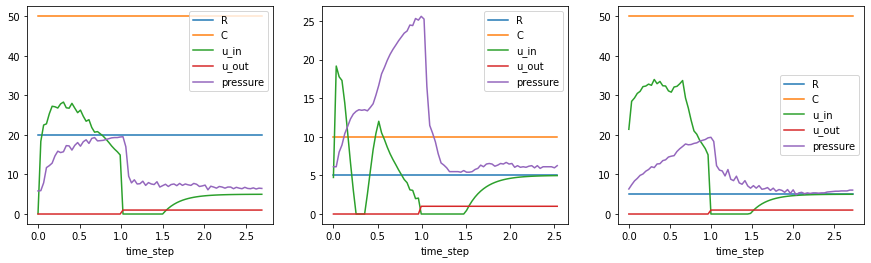

In [5]:
fig = plt.figure(figsize=(15,4))

ax = plt.subplot(131)
breath = data[data['breath_id'] == 1]
breath.plot(x='time_step', y=['R','C', 'u_in', 'u_out', 'pressure'], ax=ax)

ax = plt.subplot(132)
breath = data[data['breath_id'] == 100]
breath.plot(x='time_step', y=['R','C', 'u_in', 'u_out', 'pressure'], ax=ax)

ax = plt.subplot(133)
breath = data[data['breath_id'] == 5]
breath.plot(x='time_step', y=['R','C', 'u_in', 'u_out', 'pressure'], ax=ax)

plt.show()
plt.close()

 - R and C remain constant throughout a breath
 - pressure rises when u_out=0, then drops and fluctuates when u_out=1
 - u_in can have a complex pattern while u_out=0, then is set to 0 when u_out first opens, and then rises as $\propto$ (1-exp(1/x)) or so
 - clearly, pressure has a significant memory effect (duh), and the history of pressure is very important in predicting the future value
 - however, **some of the rapid fluctuations in pressure may not be significant** (they may be temporary obstrucitons in the airways, e.g.) -- removing them through pre-smoothing the pressure time series may be beneficial

No of breaths: 75450
No of data points per breath: 80
Breath tmin: 0.0
Breath tmax: [2.68976617 2.690624   2.52539778 ... 2.72142196 2.5086534  2.63801742]


<AxesSubplot:>

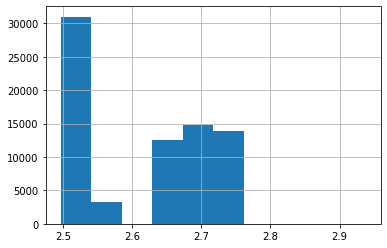

In [6]:
# How many unique breath time series do we have?
n_breaths = len(data.breath_id.unique())
print("No of breaths:", n_breaths)

breath_length = data.groupby('breath_id').C.count().unique()
if len(breath_length) == 1:
    breath_length = breath_length[0]
print("No of data points per breath:", breath_length)

breath_length_tmin = data.groupby('breath_id').time_step.min().unique()
if len(breath_length_tmin) == 1:
    breath_length_tmin = breath_length_tmin[0]
print("Breath tmin:", breath_length_tmin)

breath_length_tmax = data.groupby('breath_id').time_step.max().unique()
if len(breath_length_tmax) == 1:
    breath_length_tmax = breath_length_tmax[0]
print("Breath tmax:", breath_length_tmax)

data.groupby('breath_id').time_step.max().hist()

 - All breaths are exactly 80 time stamps long.
 - They all start at t=0
 - Their length ranges between 2.5 and 2.8, with two clear peaks -- **it may be beneficial to split the dataset into these two subpopulations later**

<AxesSubplot:>

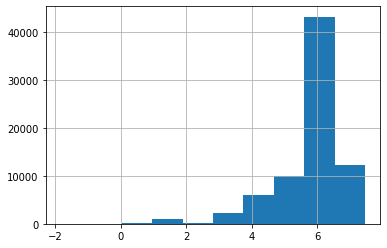

In [7]:
# What is the initial pressure? -- we will probably need to guess it..
data.groupby('breath_id').pressure.first().hist()

What are the statistics of u_out ON / OFF times?

In [8]:
print("Initial u_out state:", data.groupby('breath_id').u_out.first().unique())
print("Final u_out state:", data.groupby('breath_id').u_out.last().unique())
print("Number of u_out switches:", data.groupby('breath_id').u_out.aggregate(lambda x : np.sum(np.abs(np.array(x)[1:]-np.array(x)[:-1]))).unique())

Initial u_out state: [0]
Final u_out state: [1]
Number of u_out switches: [1]


u_out switch time step: [29 28 31 30 27 24 25]
u_out switch time: AxesSubplot(0.125,0.125;0.775x0.755)


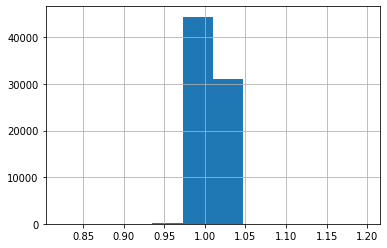

In [9]:
print("u_out switch time step:", data.groupby('breath_id').u_out.aggregate(lambda x : np.where(np.abs(np.array(x)[1:]-np.array(x)[:-1]))[0]).unique())
print("u_out switch time:", data[data.u_out > 0].groupby('breath_id').time_step.min().hist())

Ok, so each breath starts with the outflow valve closed, and then it is opened once (and only once) at time step 25-30, or about 1s.

In [10]:
data.columns

Index(['id', 'breath_id', 'R', 'C', 'time_step', 'u_in', 'u_out', 'pressure'], dtype='object')

In [11]:
# Let us create a function that will transform the pandas DataFrame into 3D array more useful for our time-series analysis
# , with an axis dedicated to breath_id
def parse_df (data):
    return np.array(list(data.groupby('breath_id').apply(np.array)))

In [12]:
npdata = parse_df(data)

In [13]:
npdata.shape

(75450, 80, 8)

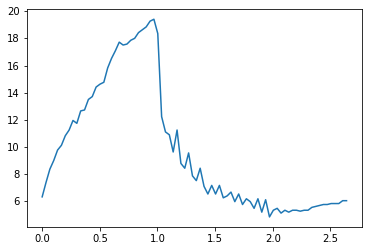

In [14]:
plt.figure()
plt.plot(npdata[233,:,4], npdata[4,:,7])
plt.show()
plt.close()

The general properties of the model should then be:
 - since we are not given any initial value, the initial pressure must be guessed based on the full feature set of other parameters,
 - features:
   - single values of R and C,
   - full time series of u_in, u_out, optionally as a function of time_step,
   - pressure values before the current time step.
 - we need to predict:
   - the time series of pressur **only** while u_out=0.
 - optional adjustments:
   - pre-smooth the pressure curve before training.
   
It is a bit odd that we know the full time series of u_in, u_out before calculting the pressures (if one thinks of it from the point of view of an actual application to a physical ventilator), but perhaps these are taken from a previous breath?

In [15]:
def preprocess (data, val_size=0.15, idx=None, submission=False):
    
    if submission:
        datasets = ['subm',]
        idx = {}
        idx['subm'] = range(len(data.breath_id.unique()))
    else:
        datasets = ['train', 'val']
        # generate indices for a train-validation split, if needed
        if not isinstance(idx, dict) and not submission:
            idx = {}
            idx['val'] = np.random.choice(n_breaths, size=int(val_size*n_breaths), replace=False)
            idx['train'] = [x for x in np.arange(n_breaths, dtype=int) if x not in idx['val']]
    
    # preprocess features
    X = {}
    for t in datasets:
        X[t] = {}
        # single-value features
        for feature in ['R', 'C']:
            X[t][feature] = np.array(data.groupby('breath_id')[feature].first())[idx[t]]
        # time series
        for feature in ['time_step', 'u_in', 'u_out']:
            X[t][feature] = np.array(list(data.groupby('breath_id')[feature].apply(np.array)))[idx[t]]
        
    # preprocess labels
    y = {}
    if 'pressure' in data.columns:
        for t in datasets:
            y[t] = {}
            y[t] = np.array(list(data.groupby('breath_id').pressure.apply(np.array)))[idx[t]]
            # limit only to the inspiratory phase
            y[t] *= (1 - np.array(list(data.groupby('breath_id').u_out.apply(np.array))))[idx[t]]
        
    return X, y, idx

In [16]:
X, y, idx = preprocess(data)

In [17]:
def score (y_pred, y_true, X=None, print_val=True, return_val=False, plot_examples=False):
    mask = np.where(y_true > 0)[0]
    result = np.mean(np.abs(y_pred-y_true)[mask])
    if print_val:
        print("Score: %.2f" % result)
    if plot_examples and isinstance(X, dict):
        # draw 3 random indices to plot
        fig = plt.figure(figsize=(15,4))
        for i in range(3):
            plt.subplot(1,3,i+1)
            idx = np.random.randint(low=0,high=len(X['time_step']))
            plt.title('Idx = %i' % idx)
            for feature in ['R', 'C']:
                plt.plot(X['time_step'][idx], X[feature][idx] * np.ones(X['time_step'][idx].shape), label=feature)
            for feature in ['u_in', 'u_out']:
                plt.plot(X['time_step'][idx], X[feature][idx], label=feature)
            plt.plot(X['time_step'][idx], y_true.reshape(X['time_step'].shape)[idx], label='True')
            plt.plot(X['time_step'][idx], y_pred.reshape(X['time_step'].shape)[idx], label='Pred')
            plt.legend()
        plt.show()
        plt.close()
    if return_val:
        return result

Score: 3.68


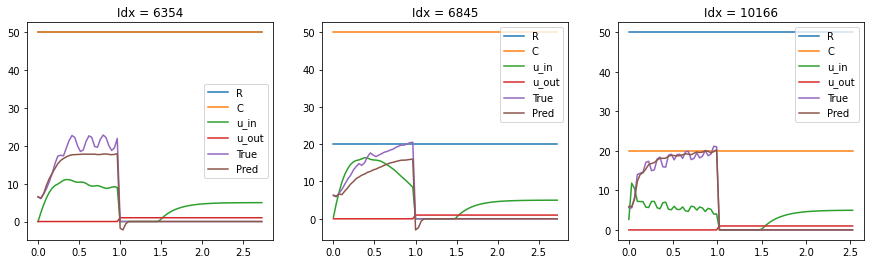

In [18]:
# As a baseline model, let's try a simple linear regression
model_name = 'baseline'
if model_name not in models_to_train.keys():
    models_to_train[model_name] = True

if display_mode or (not last_only and models_to_train[model_name]):

    from sklearn.preprocessing import StandardScaler
    from sklearn.linear_model import LinearRegression
    from sklearn.pipeline import make_pipeline

    def preprocess_sgdr (X):
        return np.concatenate([
            X['R'].reshape((-1,1)),
            X['C'].reshape((-1,1)),
            X['u_in'], 
            X['u_out'], 
        ], axis=1)

    reg = make_pipeline(StandardScaler(), LinearRegression())

    reg.fit(preprocess_sgdr(X['train']), y['train'])
    score(reg.predict(preprocess_sgdr(X['val'])).flatten(), y['val'].flatten(), X=X['val'], plot_examples=True)
    
# Score: 3.68 (1.48 taking into account only u_out==0)

In [19]:
# submit to make sure that we calculate the score properly

if False:

    data_submit = pd.read_csv('/kaggle/input/ventilator-pressure-prediction/test.csv')
    data_submit.head()

    X_submit, _, _ = preprocess(data_submit, submission=True)

    data_submit['pressure'] = reg.predict(preprocess_sgdr(X_submit['subm'])).flatten()

    data_submit[['id','pressure']].to_csv('submission.csv', index=False)

The submission gives a score of 3.71, so now we know that our scoring implementation is correct. Let's work to improve the model!

The space of the input is not terribly large, we have 2+2*80 = 162 features, not counting the past pressure predictions.. Thus, we may be able to get something useful with just a simple deep neural network.

In [20]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

In [21]:
model_name = 'simple_dense_block'
if model_name not in models_to_train.keys():
    models_to_train[model_name] = True

if not last_only and models_to_train[model_name]:

    def preprocess_nn (X):
        return np.dstack([
            np.concatenate([X['R'].reshape((-1,1)),X['u_in']], axis=1),
            np.concatenate([X['C'].reshape((-1,1)),X['u_out']], axis=1), 
        ])

    nn = models.Sequential()
    nn.add(layers.Input(shape=(81,2)))
    nn.add(layers.Flatten())
    nn.add(layers.Dense(128, activation='relu'))
    nn.add(layers.Dense(128, activation='relu'))
    nn.add(layers.Dense(128, activation='relu'))
    nn.add(layers.Dense(80))

    nn.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['RootMeanSquaredError'])

    history = nn.fit(preprocess_nn(X['train']), y['train'],
                    epochs=10,
                    validation_data=(preprocess_nn(X['val']),y['val']))

    plt.plot(history.history['root_mean_squared_error'], label='root_mean_squared_error')
    plt.plot(history.history['val_root_mean_squared_error'], label = 'val_root_mean_squared_error')
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.legend(loc='best')

    score(nn.predict(preprocess_nn(X['val'])).flatten(), y['val'].flatten(), X=X['val'], plot_examples=True)
    
# Score: 0.95

Oh, wow.. That is **much** better than SGDR!

Let us fine tune the hyperparameters of such a single-block dense neural network, to see how much we can squeeze out of it.

In [22]:
import keras_tuner as kt

In [23]:
def build_nn_singleBlock (hp):
    nn = models.Sequential()
    nn.add(layers.Input(shape=(81,2)))
    nn.add(layers.Flatten())
    #num_layers = hp.Int('num_layers',2,4)
    num_layers = hp.Int('num_layers',4,6)
    for i in range(num_layers):
        with hp.conditional_scope('num_layers', list(range(i+1,8+1))): # num > i
            if i > 0:
                nn.add(layers.Dropout(
                    hp.Float('dropout',0.,0.8,step=0.2)
                ))
            nn.add(layers.Dense(
                #2**hp.Int('logSize_layer', 3,9, step=2), # this returns 9 so might want to try larger
                2**hp.Int('logSize_layer', 8,12, step=1),
                activation='relu'
            ))
    nn.add(layers.Dense(80))
    
    nn.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=['RootMeanSquaredError',]
    )
    
    return nn

In [24]:
def fit_from_hp_dict (build_model, hp_dict, 
                      X_train, y_train,
                      X_val=None, y_val=None, validation=True,
                      early_stopping=True, epochs=1024,
                      train_model=True):
    '''Using saved HyperParameter.values dict,
    build the tuned model, train it, and plot diagnostics.'''
    best_hyperparameters = kt.HyperParameters()
    best_hyperparameters.values = hp_dict
    best_model = build_model(best_hyperparameters)
    if early_stopping:
        stop_early = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=16,
            restore_best_weights=True
        )
        callbacks = [stop_early,]
    else:
        callbacks = []
    if validation:
        validation_data=(X_val, y_val)
    else:
        validation_data=None
    
    if train_model:
        history = best_model.fit(
            X_train, y_train,
            epochs=epochs,
            validation_data=validation_data,
            callbacks=callbacks
        )
        plt.clf()
        plt.plot(history.history['loss'], label='loss')
        plt.plot(history.history['val_loss'], label = 'val_loss')
        plt.xlabel('Epoch')
        plt.ylabel('RMSE')
        plt.legend(loc='lower right')
        plt.show()
        plt.close()
        
    return best_model

In [25]:
# As a baseline model, let's try a simple linear regression
model_name = 'tuned_dense_block'
if model_name not in models_to_train.keys():
    models_to_train[model_name] = True

if not last_only and models_to_train[model_name]:

    if False:# force_retune: # or not os.path.exists('....model'):
        tuner = kt.Hyperband(
            build_nn_singleBlock,
            objective=kt.Objective('val_root_mean_squared_error',
                                        direction='min'),
            max_epochs=512,
            hyperband_iterations=2,
            overwrite=True
        )
        tuner.search(preprocess_nn(X['train']), y['train'],
               epochs=10,
               validation_data=(preprocess_nn(X['val']),y['val']))
        best_model = tuner.get_best_models(1)[0]
        best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
        # save for later reuse
        with open('nn_singleBlock.pkl', 'wb') as f:
            pkl.dump(best_hyperparameters, f)
        best_model.save('nn_singleBlock.model')
        print(best_hyperparameters.values)
    else:
        if False: # for some reason, this doesn't work with kaggle notebooks :/
            print('Loading best_model from previous tuning..', flush=True, end='')
            with open('nn_singleBlock.pkl', 'rb') as f:
                best_hyperparameters = pkl.load(f)
            best_model = models.load_model('nn_singleBlock.model')
        else:
            print('Setting hyperparameters to best from previous tuning..', flush=True)
            #best_hyperparameters_dict = {
            #    'num_layers': 3, 'logSize_layer': 9, 
            #    'dropout': 0.0, 
            #    'tuner/epochs': 3, 'tuner/initial_epoch': 0, 
            #    'tuner/bracket': 5, 'tuner/round': 0
            #} # RMSE 0.9161117672920227
            best_hyperparameters_dict = {
                'num_layers': 4, 'logSize_layer': 10, 
                'dropout': 0.0, 
                'tuner/epochs': 3, 'tuner/initial_epoch': 0, 
                'tuner/bracket': 5, 'tuner/round': 0
            } # RMSE 0.9090515971183777
            best_model = fit_from_hp_dict(
                build_nn_singleBlock, best_hyperparameters_dict, 
                preprocess_nn(X['train']), y['train'],
                preprocess_nn(X['val']),y['val'],
                train_model=True
            )
        print('done.')

    print(best_model.summary())
    score(best_model.predict(preprocess_nn(X['val'])).flatten(), y['val'].flatten(), X=X['val'], plot_examples=True)

# Score: 0.67

In [26]:
# submit

if False:

    data_submit = pd.read_csv('/kaggle/input/ventilator-pressure-prediction/test.csv')

    X_submit, _, _ = preprocess(data_submit, submission=True)

    data_submit['pressure'] = best_model.predict(preprocess_nn(X_submit['subm'])).flatten()

    print(data_submit.head())
    data_submit[['id','pressure']].to_csv('submission.csv', index=False)

The greatest missing point in our models so far is probably the omission of the fact that any pressure value is very dependent on the previous pressure values in the series. Let us try and take this fact into account.

To start simple, we can add a polynomial of time stamp values to our linear model to filter out any trends and seasonality.

In [27]:
X['train'].keys()

dict_keys(['R', 'C', 'time_step', 'u_in', 'u_out'])

In [28]:
# As a baseline model, let's try a simple linear regression
model_name = 'LinReg_with_time'
if model_name not in models_to_train.keys():
    models_to_train[model_name] = True

if not last_only and models_to_train[model_name]:
    
    from sklearn.preprocessing import StandardScaler
    from sklearn.linear_model import LinearRegression
    from sklearn.pipeline import make_pipeline

    def preprocess_sgdr (X, time_order=0):
        if time_order == 0:
            times = [len(X['R']) * [[],],]
        else:
            times = []
            for n in range(1,time_order+1):
                times.append(X['time_step']**n)
        return np.concatenate(
            times + [
            X['R'].reshape((-1,1)),
            X['C'].reshape((-1,1)),
            X['u_in'], 
            X['u_out'], 
        ], axis=1)

    reg = make_pipeline(StandardScaler(), LinearRegression())

    for time_order in range(5):
        print("time_order = %i" % time_order)
        reg.fit(preprocess_sgdr(X['train'], time_order=time_order), y['train'])
        score(reg.predict(preprocess_sgdr(X['val'], time_order=time_order)).flatten(), y['val'].flatten(), X=X['val'], plot_examples=True)

# Scores: 3.7 -- 3.9

Well, this doesn't help at all. Let us continue ignoring the time_step feature then, it doesn't seem to be relevant.

Instead, let us focus on taking into account previously predicted pressure values in predicting the new pressure value. Since our NN performs much better than the linear model anyway, it is perhaps best to include this information there.. In principle, it may just do to replace the last of Dense layers in the network with an LSTM layer. Let's test this on our test NN, to quickly see the difference.

In [29]:
model_name = 'LSTM_corrective'
if model_name not in models_to_train.keys():
    models_to_train[model_name] = True

if not last_only and models_to_train[model_name]:

    print("LSTM as a correction step:")

    # use the pre-trained deep model from before
    nn = models.clone_model(best_model)
    for layer in nn.layers:
        layer.trainable=False

    # use lstm for correction
    nn.add(layers.Reshape((80,1)))
    nn.add(layers.LSTM(128))
    nn.add(layers.Dense(80))

    nn.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['RootMeanSquaredError'])

    nn.summary()

    stop_early = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=16,
        restore_best_weights=True
    )
    callbacks = [stop_early,] 

    if train_all:

        history = nn.fit(preprocess_nn(X['train']), y['train'],
                        epochs=1024,
                        validation_data=(preprocess_nn(X['val']),y['val']),
                        callbacks=callbacks)

        plt.plot(history.history['root_mean_squared_error'], label='root_mean_squared_error')
        plt.plot(history.history['val_root_mean_squared_error'], label = 'val_root_mean_squared_error')
        plt.xlabel('Epoch')
        plt.ylabel('RMSE')
        plt.legend(loc='best')

        score(nn.predict(preprocess_nn(X['val'])).flatten(), y['val'].flatten(), X=X['val'], plot_examples=True)

# Score: 1.06

In [30]:
model_name = 'LSTM_simple_noFuture'
if model_name not in models_to_train.keys():
    models_to_train[model_name] = True

if not last_only and models_to_train[model_name]:

    print("LSTM only (no future data):")

    def preprocess_lstm (X):
        return np.dstack([
            np.tile(X['R'], (80,1)).transpose(), 
            np.tile(X['C'], (80,1)).transpose(), 
            X['u_in'], X['u_out']])

    # use lstm for correction
    nn = models.Sequential()
    nn.add(layers.Input(shape=(80,4)))
    nn.add(layers.LSTM(512))
    nn.add(layers.Dense(512, activation='relu'))
    nn.add(layers.Dense(512, activation='relu'))
    nn.add(layers.Dense(80))

    nn.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['RootMeanSquaredError'])

    nn.summary()

    stop_early = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=16,
        restore_best_weights=True
    )
    callbacks = [stop_early,]

    history = nn.fit(preprocess_lstm(X['train']), y['train'],
                    epochs=1024,
                    validation_data=(preprocess_lstm(X['val']),y['val']),
                    callbacks=callbacks)

    plt.plot(history.history['root_mean_squared_error'], label='root_mean_squared_error')
    plt.plot(history.history['val_root_mean_squared_error'], label = 'val_root_mean_squared_error')
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.legend(loc='best')

    score(nn.predict(preprocess_lstm(X['val'])).flatten(), y['val'].flatten(), X=X['val'], plot_examples=True)

# Score: 0.54

LSTM hybrid (future data mixed-in):


2022-01-31 14:26:20.196463: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-01-31 14:26:20.199963: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-01-31 14:26:20.246164: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-31 14:26:20.246778: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2022-01-31 14:26:20.246838: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-01-31 14:26:20.287023: I tensorflow/stream_executor/platform/def

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 80, 512)           2560      
_________________________________________________________________
lstm (LSTM)                  (None, 512)               2099200   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_2 (Dense)              (None, 80)                41040     
Total params: 2,405,456
Trainable params: 2,405,456
Non-trainable params: 0
_________________________________________________________________


2022-01-31 14:26:22.758654: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-01-31 14:26:22.768231: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2000140000 Hz


Epoch 1/1024


2022-01-31 14:26:24.092475: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-01-31 14:26:24.895731: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022-01-31 14:26:24.958887: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8


2005/2005 [==============================] - 42s 17ms/step - loss: 22.3006 - root_mean_squared_error: 4.6392 - val_loss: 6.3948 - val_root_mean_squared_error: 2.5288
Epoch 2/1024
2005/2005 [==============================] - 34s 17ms/step - loss: 5.8380 - root_mean_squared_error: 2.4158 - val_loss: 4.6537 - val_root_mean_squared_error: 2.1572
Epoch 3/1024
2005/2005 [==============================] - 34s 17ms/step - loss: 4.6648 - root_mean_squared_error: 2.1596 - val_loss: 4.0409 - val_root_mean_squared_error: 2.0102
Epoch 4/1024
2005/2005 [==============================] - 34s 17ms/step - loss: 3.9529 - root_mean_squared_error: 1.9880 - val_loss: 4.2931 - val_root_mean_squared_error: 2.0720
Epoch 5/1024
2005/2005 [==============================] - 34s 17ms/step - loss: 3.5528 - root_mean_squared_error: 1.8846 - val_loss: 3.0839 - val_root_mean_squared_error: 1.7561
Epoch 6/1024
2005/2005 [==============================] - 34s 17ms/step - loss: 3.2220 - root_mean_squared_error: 1.7949 -

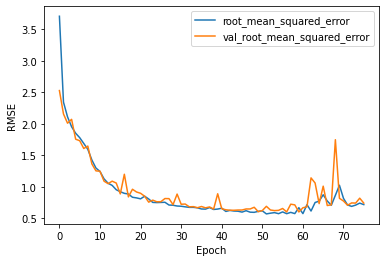

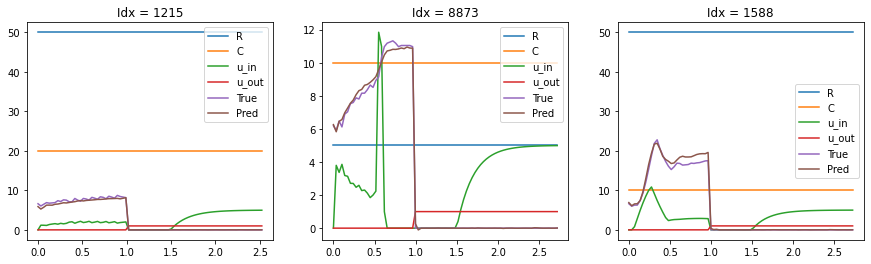

In [31]:
model_name = 'LSTM_simple_hybrid'
if model_name not in models_to_train.keys():
    models_to_train[model_name] = True

if display_mode or (not last_only and models_to_train[model_name]):

    print("LSTM hybrid (future data mixed-in):")

    def preprocess_lstm (X):
        return np.dstack([
            np.tile(X['R'], (80,1)).transpose(), 
            np.tile(X['C'], (80,1)).transpose(), 
            X['u_in'], X['u_out']])

    nn = models.Sequential()
    nn.add(layers.Input(shape=(80,4)))
    nn.add(layers.Dense(512, activation='relu'))
    nn.add(layers.LSTM(512))
    nn.add(layers.Dense(512, activation='relu'))
    nn.add(layers.Dense(80))

    nn.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['RootMeanSquaredError'])

    nn.summary()

    stop_early = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=16,
        restore_best_weights=True
    )
    callbacks = [stop_early,] 

    history = nn.fit(preprocess_lstm(X['train']), y['train'],
                    epochs=1024,
                    validation_data=(preprocess_lstm(X['val']),y['val']),
                    callbacks=callbacks)

    plt.plot(history.history['root_mean_squared_error'], label='root_mean_squared_error')
    plt.plot(history.history['val_root_mean_squared_error'], label = 'val_root_mean_squared_error')
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.legend(loc='best')

    score(nn.predict(preprocess_lstm(X['val'])).flatten(), y['val'].flatten(), X=X['val'], plot_examples=True)

# Score: 0.54

Ok, so using the LSTM as a correction step to our Dense neural network doesn't really help, but an LSTM network trained from scratch does do a bit better than just Dense layers, regardless of where the LSTM layer is. Let's use it to calculate a new submission then!

In [32]:
# submit
if False:
    data_submit = pd.read_csv('/kaggle/input/ventilator-pressure-prediction/test.csv')

    X_submit, _, _ = preprocess(data_submit, submission=True)
    data_submit['pressure'] = nn.predict(preprocess_lstm(X_submit['subm'])).flatten()

    print(data_submit.head())
    data_submit[['id','pressure']].to_csv('submission.csv', index=False)

Nice. Note that the LSTM network takes a long time to train. Before we proceed and tune it, it would be useful to adjust the loss function of our training so that it matches the competition's scoring function (at the moment, our loss takes into account the full pressure curve, while only the part with pressure > 0 is scored).

In [33]:
def competition_loss (y_true, y_pred):
    #return tf.experimental.numpy.nanmean(tf.where(y_true > 0, tf.abs(y_true-y_pred), np.nan))
    return tf.experimental.numpy.nanmean(tf.where(y_true > 0, (y_true-y_pred)**2, np.nan))

In [34]:
model_name = 'simple_dense_compLoss'
if model_name not in models_to_train.keys():
    models_to_train[model_name] = True

if not last_only and models_to_train[model_name]:

    # quick test to see if it works
    def preprocess_nn (X):
        return np.dstack([
            np.concatenate([X['R'].reshape((-1,1)),X['u_in']], axis=1),
            np.concatenate([X['C'].reshape((-1,1)),X['u_out']], axis=1), 
        ])

    nn = models.Sequential()
    nn.add(layers.Input(shape=(81,2)))
    nn.add(layers.Flatten())
    nn.add(layers.Dense(128, activation='relu'))
    nn.add(layers.Dense(128, activation='relu'))
    nn.add(layers.Dense(128, activation='relu'))
    nn.add(layers.Dense(80))

    nn.compile(optimizer='adam',
              loss=competition_loss)

    history = nn.fit(preprocess_nn(X['train']), y['train'],
        epochs=10,
        validation_data=(preprocess_nn(X['val']),y['val']))

    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label = 'val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='best')

    score(nn.predict(preprocess_nn(X['val'])).flatten(), y['val'].flatten(), X=X['val'], plot_examples=True)

# Score: 0.88

Great! And the score indeed gets a bit better (it was ~1 originally).

Now, let's use this loss function to re-tune out single-block dense NN, and the LSTM network..

In [35]:
def build_nn_singleBlock_comploss (hp):
    nn = models.Sequential()
    nn.add(layers.Input(shape=(81,2)))
    nn.add(layers.Flatten())
    num_layers = hp.Int('num_layers',3,5)
    for i in range(num_layers):
        with hp.conditional_scope('num_layers', list(range(i+1,8+1))): # num > i
            if i > 0:
                nn.add(layers.Dropout(
                    hp.Float('dropout',0.,0.8,step=0.2)
                ))
            nn.add(layers.Dense(
                2**hp.Int('logSize_layer', 8,12, step=1),
                activation='relu'
            ))
    nn.add(layers.Dense(80))
    
    nn.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=competition_loss
    )
    
    return nn

In [36]:
model_name = 'tuned_dense_compLoss'
if model_name not in models_to_train.keys():
    models_to_train[model_name] = True

if not last_only and models_to_train[model_name]:

    if False:# force_retune: # or not os.path.exists('....model'):
        tuner = kt.Hyperband(
            build_nn_singleBlock_comploss,
            objective=kt.Objective('val_loss',
                                        direction='min'),
            max_epochs=512,
            hyperband_iterations=2,
            overwrite=True
        )
        tuner.search(preprocess_nn(X['train']), y['train'],
               epochs=10,
               validation_data=(preprocess_nn(X['val']),y['val']))
        best_model = tuner.get_best_models(1)[0]
        best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
        # save for later reuse
        with open('nn_singleBlock.pkl', 'wb') as f:
            pkl.dump(best_hyperparameters, f)
        best_model.save('nn_singleBlock.model')
        print(best_hyperparameters.values)
    else:
        if False: # for some reason, this doesn't work with kaggle notebooks :/
            print('Loading best_model from previous tuning..', flush=True, end='')
            with open('nn_singleBlock.pkl', 'rb') as f:
                best_hyperparameters = pkl.load(f)
            best_model = models.load_model('nn_singleBlock.model')
        else:
            print('Setting hyperparameters to best from previous tuning..', flush=True)
            best_hyperparameters_dict = {
                'num_layers': 4, 'logSize_layer': 10, 
                'dropout': 0.0, 
                'tuner/epochs': 3, 'tuner/initial_epoch': 0, 
                'tuner/bracket': 5, 'tuner/round': 0
            }
            best_model = fit_from_hp_dict(
                build_nn_singleBlock_comploss, best_hyperparameters_dict, 
                preprocess_nn(X['train']), y['train'],
                preprocess_nn(X['val']),y['val'],
                train_model=True
            )
        print('done.')

    print(best_model.summary())
    if train_all:
        score(best_model.predict(preprocess_nn(X['val'])).flatten(), y['val'].flatten(), X=X['val'], plot_examples=True)

# Score: 0.63

In [37]:
# submit
if False:
    data_submit = pd.read_csv('/kaggle/input/ventilator-pressure-prediction/test.csv')

    X_submit, _, _ = preprocess(data_submit, submission=True)
    data_submit['pressure'] = best_model.predict(preprocess_nn(X_submit['subm'])).flatten()

    print(data_submit.head())
    data_submit[['id','pressure']].to_csv('submission.csv', index=False)

In [38]:
model_name = 'LSTM_hybrid_compLoss'
if model_name not in models_to_train.keys():
    models_to_train[model_name] = True

if not last_only and models_to_train[model_name]:

    print("LSTM hybrid (future data mixed-in):")

    def preprocess_lstm (X):
        return np.dstack([
            np.tile(X['R'], (80,1)).transpose(), 
            np.tile(X['C'], (80,1)).transpose(), 
            X['u_in'], X['u_out']])

    nn = models.Sequential()
    nn.add(layers.Input(shape=(80,4)))
    nn.add(layers.Dense(512, activation='relu'))
    nn.add(layers.LSTM(512))
    nn.add(layers.Dense(512, activation='relu'))
    nn.add(layers.Dense(80))

    nn.compile(optimizer='adam',
              loss=competition_loss)

    nn.summary()

    stop_early = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=16,
        restore_best_weights=True
    )
    callbacks = [stop_early,]

    history = nn.fit(preprocess_lstm(X['train']), y['train'],
                    epochs=1024,
                    validation_data=(preprocess_lstm(X['val']),y['val']),
                    callbacks=callbacks)

    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label = 'val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='best')

    score(nn.predict(preprocess_lstm(X['val'])).flatten(), y['val'].flatten(), X=X['val'], plot_examples=True)

# Score: 0.66

In [39]:
# submit
if False:
    data_submit = pd.read_csv('/kaggle/input/ventilator-pressure-prediction/test.csv')

    X_submit, _, _ = preprocess(data_submit, submission=True)
    data_submit['pressure'] = nn.predict(preprocess_lstm(X_submit['subm'])).flatten()

    print(data_submit.head())
    data_submit[['id','pressure']].to_csv('submission.csv', index=False)

Interesting! So discarding the exhale phase improves the deep network predictions (slightly), but worsens the LSTM ones. In hindsight, it does make sense -- LSTM learns to predict the time evolution of the system, so it benefits from using the full time range given.

Let us then tune the LSTM network with the RMSE loss, as initially used.

In [40]:
print("LSTM hybrid (future data mixed-in):")

def preprocess_lstm (X):
    return np.dstack([
        np.tile(X['R'], (80,1)).transpose(), 
        np.tile(X['C'], (80,1)).transpose(), 
        X['u_in'], X['u_out']])

def build_LSTMhybrid (hp):
    nn = models.Sequential()
    nn.add(layers.Input(shape=(80,4)))
    # pre-conditioning with Dense layers
    #num_layers_DensePre = hp.Int('num_layers_DensePre',0,2)
    #for i in range(num_layers_DensePre):
    #    with hp.conditional_scope('num_layers_DensePre', list(range(i+1,8+1))): # num > i
    #        #if i > 0:
    #        #    nn.add(layers.Dropout(
    #        #        hp.Float('dropout',0.,0.4,step=0.2)
    #        #    ))
    #        nn.add(layers.Dense(
    #            2**hp.Int('logSize_DensePre', 8,10, step=1),
    #            activation='relu'
    #        ))
    # LSTM layer
    nn.add(layers.LSTM(
        2**hp.Int('logSize_LSTM', 10,12, step=1)
    ))
    # post-processing with Dense layers
    num_layers_DensePost = hp.Int('num_layers_DensePost',3,5)
    for i in range(num_layers_DensePost):
        with hp.conditional_scope('num_layers_DensePost', list(range(i+1,8+1))): # num > i
            #if i > 0:
            #    nn.add(layers.Dropout(
            #        hp.Float('dropout',0.,0.4,step=0.2)
            #    ))
            nn.add(layers.Dense(
                2**hp.Int('logSize_DensePost', 10,12, step=1),
                activation='relu'
            ))
    nn.add(layers.Dense(80))
    
    nn.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=['RootMeanSquaredError',]
    )
    
    return nn

LSTM hybrid (future data mixed-in):


In [41]:
model_name = 'tuned_LSTM_hybrid'
if model_name not in models_to_train.keys():
    models_to_train[model_name] = True

if not last_only and models_to_train[model_name]:
    
    if False:# force_retune: # or not os.path.exists('....model'):
        tuner = kt.Hyperband(
            build_LSTMhybrid,
            objective=kt.Objective('val_root_mean_squared_error',
                                        direction='min'),
            max_epochs=512,
            hyperband_iterations=2,
            overwrite=True
        )
        tuner.search(preprocess_lstm(X['train']), y['train'],
               epochs=10,
               validation_data=(preprocess_lstm(X['val']),y['val']))
        best_model = tuner.get_best_models(1)[0]
        best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
        # save for later reuse
        with open('nn_singleBlock.pkl', 'wb') as f:
            pkl.dump(best_hyperparameters, f)
        best_model.save('nn_singleBlock.model')
        print(best_hyperparameters.values)
    else:
        if False: # for some reason, this doesn't work with kaggle notebooks :/
            print('Loading best_model from previous tuning..', flush=True, end='')
            with open('nn_singleBlock.pkl', 'rb') as f:
                best_hyperparameters = pkl.load(f)
            best_model = models.load_model('nn_singleBlock.model')
        else:
            print('Setting hyperparameters to best from previous tuning..', flush=True)
            #best_hyperparameters_dict = {
            #    'num_layers_DensePre': 0, 'logSize_LSTM': 10, 
            #    'num_layers_DensePost': 3, 'logSize_DensePost': 10, 
            #    'tuner/epochs': 3, 'tuner/initial_epoch': 0, 
            #    'tuner/bracket': 5, 'tuner/round': 0
            #} # Score: 0.60
            best_hyperparameters_dict = {
                'logSize_LSTM': 10, # tuner found 12, but it takes forever to train...
                'num_layers_DensePost': 3, 
                'logSize_DensePost': 12, 'tuner/epochs': 3, 
                'tuner/initial_epoch': 0, 'tuner/bracket': 5, 
                'tuner/round': 0
            } # Score: 0.57
            best_model = fit_from_hp_dict(
                build_LSTMhybrid, best_hyperparameters_dict, 
                preprocess_lstm(X['train']), y['train'],
                preprocess_lstm(X['val']),y['val'],
                train_model=True
            )
        print('done.')

    print(best_model.summary())
    score(best_model.predict(preprocess_lstm(X['val'])).flatten(), y['val'].flatten(), X=X['val'], plot_examples=True)

# Score: 0.57

In [42]:
# submit
if False:
    data_submit = pd.read_csv('/kaggle/input/ventilator-pressure-prediction/test.csv')

    X_submit, _, _ = preprocess(data_submit, submission=True)
    data_submit['pressure'] = best_model.predict(preprocess_lstm(X_submit['subm'])).flatten()

    print(data_submit.head())
    data_submit[['id','pressure']].to_csv('submission.csv', index=False)

There does not seem to be any real improvement over our generic LSTM network (which still holds the best result...). Let us look at the problem differently then. Let's come back to the generic LSTM network (which is fairly small and reasonably easy to train) and inspect the cases where its prediction on our validation set were the worst.

LSTM hybrid (future data mixed-in):
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 80, 512)           2560      
_________________________________________________________________
lstm_1 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_5 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_6 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_7 (Dense)              (None, 80)                41040     
Total params: 2,930,768
Trainable params: 2,930,768
Non-trainable params: 0
________

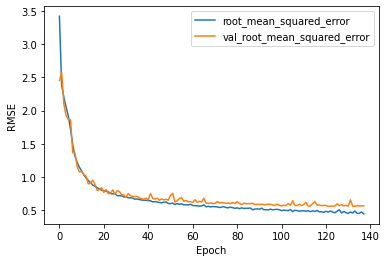

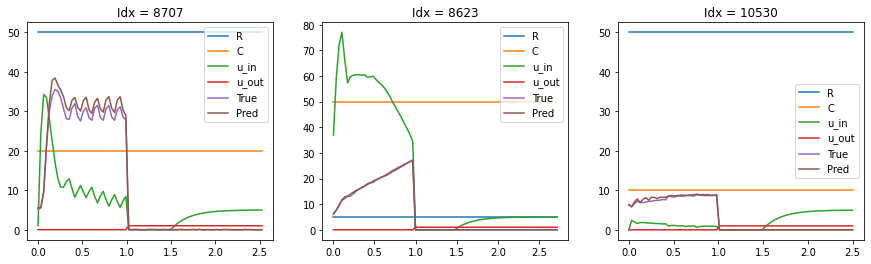

2022-01-31 16:36:56.140068: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [43]:
model_name = 'split_LSTM_hybrid'
if model_name not in models_to_train.keys():
    models_to_train[model_name] = True

if display_mode or (not last_only and models_to_train[model_name]):

    print("LSTM hybrid (future data mixed-in):")

    def preprocess_lstm (X):
        return np.dstack([
            np.tile(X['R'], (80,1)).transpose(), 
            np.tile(X['C'], (80,1)).transpose(), 
            X['u_in'], X['u_out']])

    nn = models.Sequential()
    nn.add(layers.Input(shape=(80,4)))
    nn.add(layers.Dense(512, activation='relu'))
    nn.add(layers.LSTM(512))
    nn.add(layers.Dense(512, activation='relu'))
    nn.add(layers.Dense(512, activation='relu'))
    nn.add(layers.Dense(512, activation='relu'))
    nn.add(layers.Dense(80))

    nn.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['RootMeanSquaredError'])

    nn.summary()

    stop_early = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=16,
        restore_best_weights=True
    )
    callbacks = [stop_early,] 

    if True:# train_all:

        history = nn.fit(preprocess_lstm(X['train']), y['train'],
                        epochs=1024,
                        validation_data=(preprocess_lstm(X['val']),y['val']),
                        callbacks=callbacks)

        plt.plot(history.history['root_mean_squared_error'], label='root_mean_squared_error')
        plt.plot(history.history['val_root_mean_squared_error'], label = 'val_root_mean_squared_error')
        plt.xlabel('Epoch')
        plt.ylabel('RMSE')
        plt.legend(loc='best')

        score(nn.predict(preprocess_lstm(X['val'])).flatten(), y['val'].flatten(), X=X['val'], plot_examples=True)

        nn.save('genericLSTM.model')

    else:

        nn = keras.models.load_model('genericLSTM.model')
        score(nn.predict(preprocess_lstm(X['val'])).flatten(), y['val'].flatten(), X=X['val'], plot_examples=True)

# Score: 0.54

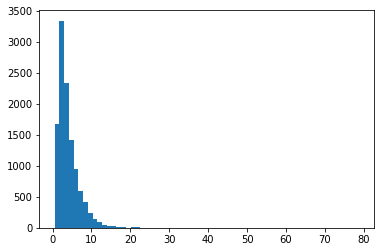

[8966 5522 9634 2707 7265 8565 3562 2604 4633 7816 5799 7582  651 6926
 3471 6959]
[ 9612  1158  8128  8307  2985  9937  7979  4602  5606  1870  7529  5118
  3823  7630  7580 10641]


In [44]:
if display_mode or (not last_only and models_to_train[model_name]):

    predictions = nn.predict(preprocess_lstm(X['val']))
    truth = y['val']
    difference = np.sqrt(np.sum((predictions - truth)**2, axis=1))
    
    plt.hist(difference, 64)
    plt.show()
    plt.close()
    
    best_indices = np.argpartition(difference, 16)[:16]
    print(best_indices)

    worst_indices = np.argpartition(difference, -16)[-16:]
    print(worst_indices)

Hmm there are no clear sub-populations visible in our predictions. So splitting the sample to use two different models can be more difficult than expected..

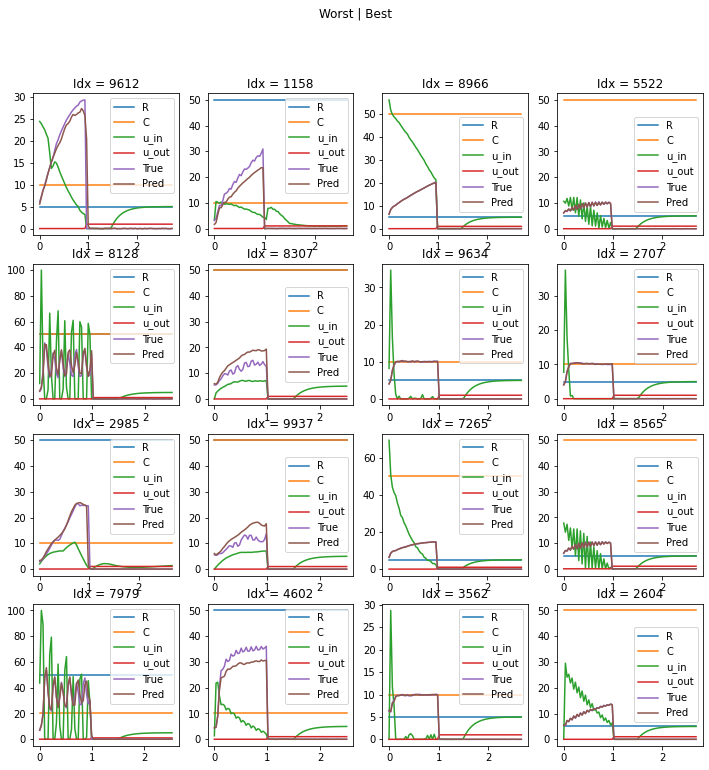

In [45]:
if display_mode or (not last_only and models_to_train[model_name]):

    fig = plt.figure(figsize=(12,12))
    for j in range(4):
        plt.suptitle("Worst | Best ")
        for i in range(2):
            idx = worst_indices[2*j+i]
            plt.subplot(4,4,4*j+i+1)
            plt.title('Idx = %i' % idx)
            for feature in ['R', 'C']:
                plt.plot(X['val']['time_step'][idx], X['val'][feature][idx] * np.ones(X['val']['time_step'][idx].shape), label=feature)
            for feature in ['u_in', 'u_out']:
                plt.plot(X['val']['time_step'][idx], X['val'][feature][idx], label=feature)
            plt.plot(X['val']['time_step'][idx], truth[idx], label='True')
            plt.plot(X['val']['time_step'][idx], predictions[idx], label='Pred')
            plt.legend()
        for i in range(2):
            idx = best_indices[2*j+i]
            plt.subplot(4,4,4*j+i+3)
            plt.title('Idx = %i' % idx)
            for feature in ['R', 'C']:
                plt.plot(X['val']['time_step'][idx], X['val'][feature][idx] * np.ones(X['val']['time_step'][idx].shape), label=feature)
            for feature in ['u_in', 'u_out']:
                plt.plot(X['val']['time_step'][idx], X['val'][feature][idx], label=feature)
            plt.plot(X['val']['time_step'][idx], truth[idx], label='True')
            plt.plot(X['val']['time_step'][idx], predictions[idx], label='Pred')
            plt.legend()
    plt.show()
    plt.close()

By eye, it's not immediately clear to me what is the underlying difference between the cases that were predicted correctly, and the incorrect predictions. Let us try to automate this process. Lets take the best 25% and the worst 25% of predictions, and try to make a classifier predicting whether a given case corresponds to the latter class (given only its feature values).

In [46]:
if display_mode or (not last_only and models_to_train[model_name]):

    no_samples = int(0.25*len(y['val']))

    best_indices = np.argpartition(difference, no_samples)[:no_samples]

    worst_indices = np.argpartition(difference, -no_samples)[-no_samples:]

    all_indices = np.concatenate([best_indices,worst_indices])

In [47]:
if display_mode or (not last_only and models_to_train[model_name]):

    def preprocess_lstm (X):
        return np.dstack([
            np.tile(X['R'], (80,1)).transpose(), 
            np.tile(X['C'], (80,1)).transpose(), 
            X['u_in'], X['u_out']])
    def preprocess_class (X, selection=[]):
        X_class = {}
        if len(selection) > 0:
            for key in X.keys():
                X_class[key] = X[key][all_indices]
        else:
            for key in X.keys():
                X_class[key] = 1 * X[key]
        X_class = preprocess_lstm(X_class)
        X_class = X_class.reshape(X_class.shape[0],-1)
        return X_class
    X_class = preprocess_class(X['val'], selection=all_indices)

    y_class = np.concatenate([np.zeros(no_samples), np.ones(no_samples)])

    print(X_class.shape, y_class.shape)

(5658, 320) (5658,)


In [48]:
if display_mode or (not last_only and models_to_train[model_name]):

    from sklearn.linear_model import SGDClassifier
    clf = SGDClassifier(loss="hinge", penalty="l2", max_iter=5)

    clf.fit(X_class, y_class)

    from sklearn.metrics import classification_report
    print(classification_report(y_class, clf.predict(X_class)))

              precision    recall  f1-score   support

         0.0       0.80      0.81      0.81      2829
         1.0       0.81      0.80      0.80      2829

    accuracy                           0.80      5658
   macro avg       0.80      0.80      0.80      5658
weighted avg       0.80      0.80      0.80      5658



/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_stochastic_gradient.py:573: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


In [49]:
if display_mode or (not last_only and models_to_train[model_name]):
    from sklearn.pipeline import make_pipeline
    from sklearn.preprocessing import StandardScaler
    from sklearn.svm import SVC
    clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
    clf.fit(X_class, y_class)
    print(classification_report(y_class, clf.predict(X_class)))

              precision    recall  f1-score   support

         0.0       0.86      0.89      0.87      2829
         1.0       0.89      0.85      0.87      2829

    accuracy                           0.87      5658
   macro avg       0.87      0.87      0.87      5658
weighted avg       0.87      0.87      0.87      5658



This may be good enough for now, we can always make something more sophisticated later.

Let's use this classifier to build two different versions of our LSTM network -- one for the "easy" cases (with class 0) and one for the "hard" ones (with class 1).

In [50]:
if display_mode or (not last_only and models_to_train[model_name]):
    train_classes = clf.predict(preprocess_class(X['train']))
    val_classes = clf.predict(preprocess_class(X['val']))

In [51]:
if display_mode or (not last_only and models_to_train[model_name]):

    def preprocess_lstm (X):
        return np.dstack([
            np.tile(X['R'], (80,1)).transpose(), 
            np.tile(X['C'], (80,1)).transpose(), 
            X['u_in'], X['u_out']])

    X_all = preprocess_lstm(X['train'])

    X_train_easy = X_all[train_classes == 0]
    y_train_easy = y['train'][train_classes == 0]

    X_train_hard = X_all[train_classes == 1]
    y_train_hard = y['train'][train_classes == 1]

    print(X_train_easy.shape, y_train_easy.shape)
    print(X_train_hard.shape, y_train_hard.shape)

    X_all = preprocess_lstm(X['val'])

    X_val_easy = X_all[val_classes == 0]
    y_val_easy = y['val'][val_classes == 0]

    X_val_hard = X_all[val_classes == 1]
    y_val_hard = y['val'][val_classes == 1]

    print(X_val_easy.shape, y_val_easy.shape)
    print(X_val_hard.shape, y_val_hard.shape)

(33778, 80, 4) (33778, 80)
(30355, 80, 4) (30355, 80)
(5906, 80, 4) (5906, 80)
(5411, 80, 4) (5411, 80)


In [52]:
print("Split LSTM hybrid (future data mixed-in):")

def genericLSTM_build_fit (Xtrain, ytrain, Xval, yval, base=None):

    if base == None: # train from scratch
    
        nn = models.Sequential()
        nn.add(layers.Input(shape=(80,4)))
        nn.add(layers.Dense(512, activation='relu'))
        nn.add(layers.LSTM(512))
        nn.add(layers.Dense(512, activation='relu'))
        nn.add(layers.Dense(512, activation='relu'))
        nn.add(layers.Dense(80))
        
    elif isinstance(base, str):
        
        nn = keras.models.load_model(base)
        
    else:
        
        nn = base

    nn.summary()

    nn.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['RootMeanSquaredError'])

    stop_early = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=16,
        restore_best_weights=True
    )
    callbacks = [stop_early,] 

    if train_all:

        history = nn.fit(Xtrain, ytrain,
                        epochs=1024,
                        validation_data=(Xval, yval),
                        callbacks=callbacks)

        plt.plot(history.history['root_mean_squared_error'], label='root_mean_squared_error')
        plt.plot(history.history['val_root_mean_squared_error'], label = 'val_root_mean_squared_error')
        plt.xlabel('Epoch')
        plt.ylabel('RMSE')
        plt.legend(loc='best')

        score(nn.predict(Xval).flatten(), yval.flatten(), X=Xval, plot_examples=True)
        
    return nn

Split LSTM hybrid (future data mixed-in):


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 80, 512)           2560      
_________________________________________________________________
lstm_1 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_5 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_6 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_7 (Dense)              (None, 80)                41040     
Total params: 2,930,768
Trainable params: 2,930,768
Non-trainable params: 0
____________________________________________

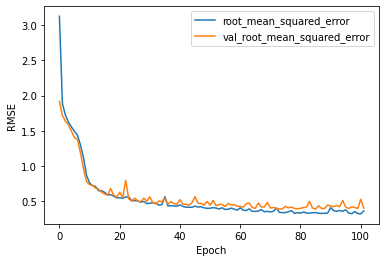

In [53]:
# Train the easy branch
if display_mode or (not last_only and models_to_train[model_name]):
    nn_easy = genericLSTM_build_fit(X_train_easy, y_train_easy, X_val_easy, y_val_easy, base=keras.models.clone_model(nn))
    nn_easy.save('SplitLSTM_easy.model')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 80, 512)           2560      
_________________________________________________________________
lstm_1 (LSTM)                (None, 512)               2099200   
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_5 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_6 (Dense)              (None, 512)               262656    
_________________________________________________________________
dense_7 (Dense)              (None, 80)                41040     
Total params: 2,930,768
Trainable params: 2,930,768
Non-trainable params: 0
____________________________________________

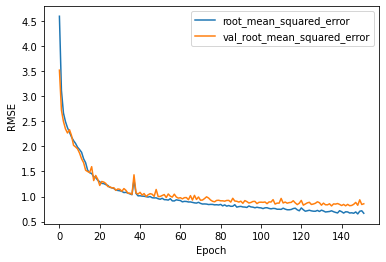

In [54]:
# Train the hard branch
if display_mode or (not last_only and models_to_train[model_name]):
    nn_hard = genericLSTM_build_fit(X_train_hard, y_train_hard, X_val_hard, y_val_hard, base=keras.models.clone_model(nn))
    nn_hard.save('SplitLSTM_hard.model')

In [55]:
# Join as a single model and score
class SplitLSTM:
    
    def __init__ (self):
        pass
    
    def predict (self,X):
        Xnn = preprocess_lstm(X)
        result = np.zeros((Xnn.shape[0],80))
        classes = clf.predict(preprocess_class(X))
        result[classes == 0] = nn_easy.predict(Xnn[classes == 0])
        result[classes == 1] = nn_hard.predict(Xnn[classes == 1])
        return result

Score: 0.62


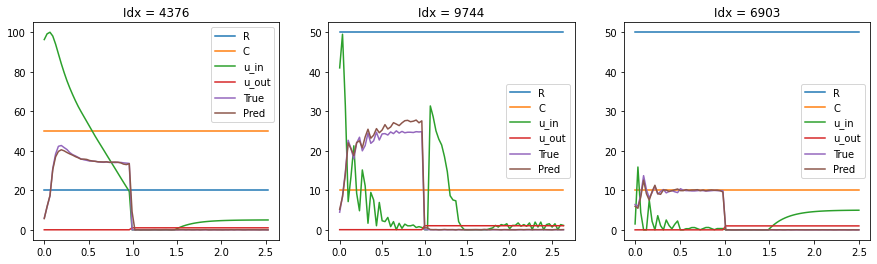

In [56]:
if display_mode or (not last_only and models_to_train[model_name]):
    splitLSTM = SplitLSTM()
    score(splitLSTM.predict(X['val']).flatten(), y['val'].flatten(), X=X['val'], plot_examples=True)

In [57]:
# submit
if False:
    data_submit = pd.read_csv('/kaggle/input/ventilator-pressure-prediction/test.csv')

    X_submit, _, _ = preprocess(data_submit, submission=True)
    data_submit['pressure'] = splitLSTM.predict(X_submit['subm']).flatten()

    print(data_submit.head())
    data_submit[['id','pressure']].to_csv('submission.csv', index=False)

Well, this is diappointing. Let us get back to our best model -- the simple generic LSTM network. During training, the network was clearly improving very slowly, with a tight correlation between training and validation data. Thus, it would benefit from more parameters. Let us try to tune it to make it wider / deeper.

First, however, let's decide on the best type of LSTM network for our work.

In [58]:
from datetime import datetime
import time

In [59]:
print("Current Time =", datetime.now().strftime("%H:%M:%S"))

Current Time = 18:16:35


In [60]:
model_name = 'LSTM_hybrid'
if model_name not in models_to_train.keys():
    models_to_train[model_name] = True

if not last_only and models_to_train[model_name]:

    print("LSTM hybrid (future data mixed-in):")
    print("Current Time =", datetime.now().strftime("%H:%M:%S"))
    start = time.time()

    def preprocess_lstm (X):
        return np.dstack([
            np.tile(X['R'], (80,1)).transpose(), 
            np.tile(X['C'], (80,1)).transpose(), 
            X['u_in'], X['u_out']])

    nn = models.Sequential()
    nn.add(layers.Input(shape=(80,4)))
    nn.add(layers.Dense(512, activation='relu'))
    nn.add(layers.LSTM(512))
    nn.add(layers.Dense(512, activation='relu'))
    nn.add(layers.Dense(512, activation='relu'))
    nn.add(layers.Dense(512, activation='relu'))
    nn.add(layers.Dense(80))

    nn.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['RootMeanSquaredError'])

    nn.summary()

    stop_early = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=16,
        restore_best_weights=True
    )
    callbacks = [stop_early,] 

    if True:# train_all:

        history = nn.fit(preprocess_lstm(X['train']), y['train'],
                        epochs=1024,
                        validation_data=(preprocess_lstm(X['val']),y['val']),
                        callbacks=callbacks)

        plt.plot(history.history['root_mean_squared_error'], label='root_mean_squared_error')
        plt.plot(history.history['val_root_mean_squared_error'], label = 'val_root_mean_squared_error')
        plt.xlabel('Epoch')
        plt.ylabel('RMSE')
        plt.legend(loc='best')

        score(nn.predict(preprocess_lstm(X['val'])).flatten(), y['val'].flatten(), X=X['val'], plot_examples=True)

        nn.save('genericLSTM.model')

    else:

        nn = keras.models.load_model('genericLSTM.model')
        score(nn.predict(preprocess_lstm(X['val'])).flatten(), y['val'].flatten(), X=X['val'], plot_examples=True)

    print("Current Time =", datetime.now().strftime("%H:%M:%S"))
    print("Elapsed [sec]: ", time.time()-start)
    
# Score: 0.57
# Training time: 4301.8sec

In [61]:
model_name = 'SimpleRNN_hybrid'
if model_name not in models_to_train.keys():
    models_to_train[model_name] = True

if not last_only and models_to_train[model_name]:

    print("SimpleRNN hybrid (future data mixed-in):")
    print("Current Time =", datetime.now().strftime("%H:%M:%S"))
    start = time.time()

    def preprocess_lstm (X):
        return np.dstack([
            np.tile(X['R'], (80,1)).transpose(), 
            np.tile(X['C'], (80,1)).transpose(), 
            X['u_in'], X['u_out']])

    nn = models.Sequential()
    nn.add(layers.Input(shape=(80,4)))
    nn.add(layers.Dense(512, activation='relu'))
    nn.add(layers.SimpleRNN(512))
    nn.add(layers.Dense(512, activation='relu'))
    nn.add(layers.Dense(512, activation='relu'))
    nn.add(layers.Dense(512, activation='relu'))
    nn.add(layers.Dense(80))

    nn.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['RootMeanSquaredError'])

    nn.summary()

    stop_early = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=16,
        restore_best_weights=True
    )
    callbacks = [stop_early,] 

    if True:# train_all:

        history = nn.fit(preprocess_lstm(X['train']), y['train'],
                        epochs=1024,
                        validation_data=(preprocess_lstm(X['val']),y['val']),
                        callbacks=callbacks)

        plt.plot(history.history['root_mean_squared_error'], label='root_mean_squared_error')
        plt.plot(history.history['val_root_mean_squared_error'], label = 'val_root_mean_squared_error')
        plt.xlabel('Epoch')
        plt.ylabel('RMSE')
        plt.legend(loc='best')

        score(nn.predict(preprocess_lstm(X['val'])).flatten(), y['val'].flatten(), X=X['val'], plot_examples=True)

        nn.save('genericLSTM.model')

    else:

        nn = keras.models.load_model('genericLSTM.model')
        score(nn.predict(preprocess_lstm(X['val'])).flatten(), y['val'].flatten(), X=X['val'], plot_examples=True)

    print("Current Time =", datetime.now().strftime("%H:%M:%S"))
    print("Elapsed [sec]: ", time.time()-start)
    
# Score: 6.27
# Training time: 6084.5sec

In [62]:
model_name = 'GRU_hybrid'
if model_name not in models_to_train.keys():
    models_to_train[model_name] = True

if not last_only and models_to_train[model_name]:

    print("GRU hybrid (future data mixed-in):")
    print("Current Time =", datetime.now().strftime("%H:%M:%S"))
    start = time.time()

    def preprocess_lstm (X):
        return np.dstack([
            np.tile(X['R'], (80,1)).transpose(), 
            np.tile(X['C'], (80,1)).transpose(), 
            X['u_in'], X['u_out']])

    nn = models.Sequential()
    nn.add(layers.Input(shape=(80,4)))
    nn.add(layers.Dense(512, activation='relu'))
    nn.add(layers.GRU(512))
    nn.add(layers.Dense(512, activation='relu'))
    nn.add(layers.Dense(512, activation='relu'))
    nn.add(layers.Dense(512, activation='relu'))
    nn.add(layers.Dense(80))

    nn.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError(),
              metrics=['RootMeanSquaredError'])

    nn.summary()

    stop_early = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=16,
        restore_best_weights=True
    )
    callbacks = [stop_early,] 

    if True:# train_all:

        history = nn.fit(preprocess_lstm(X['train']), y['train'],
                        epochs=1024,
                        validation_data=(preprocess_lstm(X['val']),y['val']),
                        callbacks=callbacks)

        plt.plot(history.history['root_mean_squared_error'], label='root_mean_squared_error')
        plt.plot(history.history['val_root_mean_squared_error'], label = 'val_root_mean_squared_error')
        plt.xlabel('Epoch')
        plt.ylabel('RMSE')
        plt.legend(loc='best')

        score(nn.predict(preprocess_lstm(X['val'])).flatten(), y['val'].flatten(), X=X['val'], plot_examples=True)

        nn.save('genericLSTM.model')

    else:

        nn = keras.models.load_model('genericLSTM.model')
        score(nn.predict(preprocess_lstm(X['val'])).flatten(), y['val'].flatten(), X=X['val'], plot_examples=True)

    print("Current Time =", datetime.now().strftime("%H:%M:%S"))
    print("Elapsed [sec]: ", time.time()-start)
    
# Score: 0.80
# Training time: 3805.7sec

Well, the LSTM model seems to work best in this configuration, with significantly better scores that the other two versions.

Since the competition deadline has now passed, I will stop here. This was fun ;)

In [63]:
last_only = False # anything after this marker is considered the "last" model and will be trained

In [64]:
print(models_to_train) # list all models created in this notebook

{'baseline': True, 'simple_dense_block': True, 'tuned_dense_block': True, 'LinReg_with_time': True, 'LSTM_corrective': True, 'LSTM_simple_noFuture': True, 'LSTM_simple_hybrid': True, 'simple_dense_compLoss': True, 'tuned_dense_compLoss': True, 'LSTM_hybrid_compLoss': True, 'tuned_LSTM_hybrid': True, 'split_LSTM_hybrid': True, 'LSTM_hybrid': True, 'SimpleRNN_hybrid': True, 'GRU_hybrid': True}
